# Лабораторна робота №5
Суміщення зображень на основі використання дескрипторів

### Завдання
Вибрати з інтернету набори зображень з різною контрастністю і різним флуктуаціями освітленості. Для кожного зображення побудувати варіант спотвореного (видозміненого зображення). Для кожної отриманої пари побудувати дескриптор і проаналізувати можливість суміщення цих зображень і з визначення параметрів геметричних перетворень (кут повороту, зміщень в напрямку х і напрямку y).

### Варіант №5

5. A-KAZE

Для перевірки збігів необхідно написати власну функцію матчінгу, а результати її роботи перевірити засобами OpenCV. Якщо повної реалізації дескриптора не має в OpenCV, то такий необхідно створити власну функцію побудови цих дискрипторів. У цьому випадку матчінг можна здійснювати стандартними засобами (якщо це можливо).

In [136]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [137]:
img1 = cv2.imread("berries.jpeg", cv2.IMREAD_GRAYSCALE)
img1_ = cv2.rotate(img1[800:1300, 800:1300], cv2.ROTATE_90_CLOCKWISE)

In [138]:
def cv_bf_matcher(image: np.ndarray, query: np.ndarray, n_matches: int = 10) -> np.ndarray:
    akaze = cv2.AKAZE_create()

    kp1, des1 = akaze.detectAndCompute(image, None)
    kp2, des2 = akaze.detectAndCompute(query, None)

    # cv2.NORM_HAMMING for binary feature descriptors
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)

    img_matches = cv2.drawMatches(image, kp1, query, kp2, matches[:n_matches], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    # img_matches = cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB)
    return img_matches

In [200]:
def custom_matcher(
        image: np.ndarray,
        query: np.ndarray,
        threshold: float = 0.5,
        n_matches: int = 10
    ) -> np.ndarray:
    akaze = cv2.AKAZE_create()

    kp1, des1 = akaze.detectAndCompute(image, None)
    kp2, des2 = akaze.detectAndCompute(query, None)

    matches = []
    for i, d1 in enumerate(des1):
        distances = np.linalg.norm(d1-des2, axis=1)
        min_idx = np.argmin(distances)
        min_dist = distances[min_idx]
        if min_dist < threshold:
            matches.append(cv2.DMatch(i, min_idx, min_dist))

    matches = sorted(matches, key=lambda x: x.distance)
    img_matches = cv2.drawMatches(image, kp1, query, kp2, matches[:n_matches], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    # img_matches = cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB)
    return img_matches

In [140]:
def show_matches(matches: np.ndarray) -> None:
    plt.figure(figsize=(16, 10))
    plt.imshow(matches)
    plt.axis("off")
    plt.show()

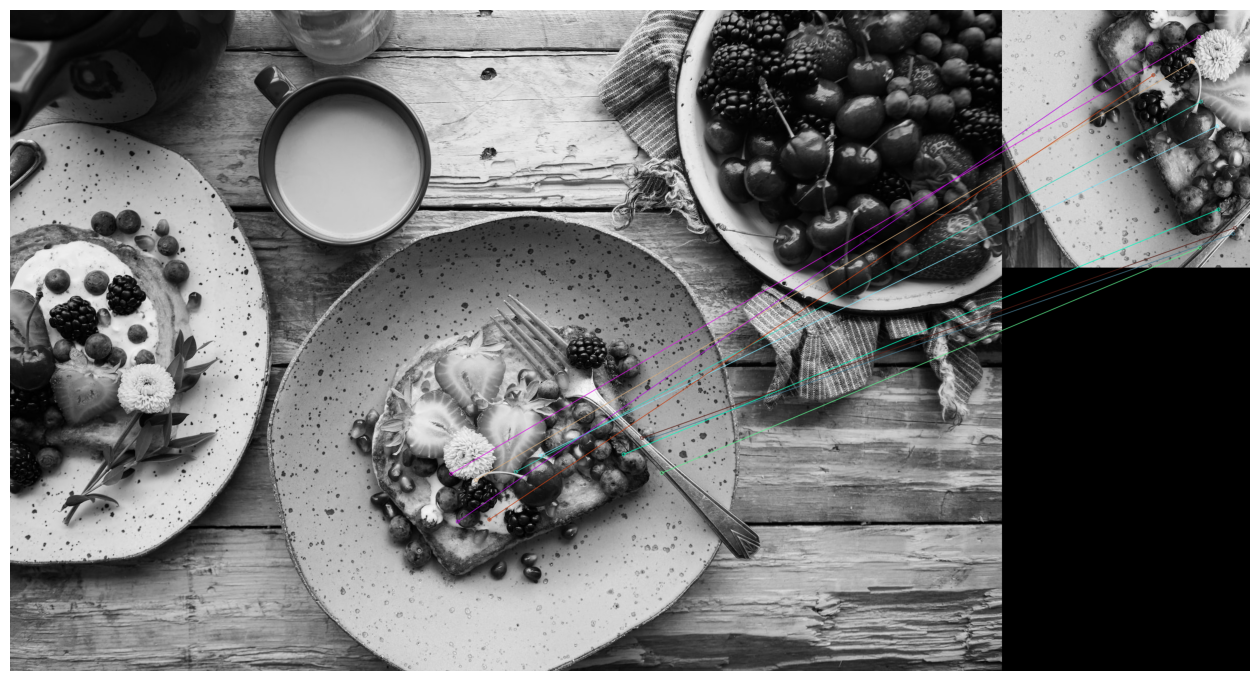

In [141]:
cv_matches = cv_bf_matcher(img1, img1_)
show_matches(cv_matches)

<class 'cv2.DMatch'>


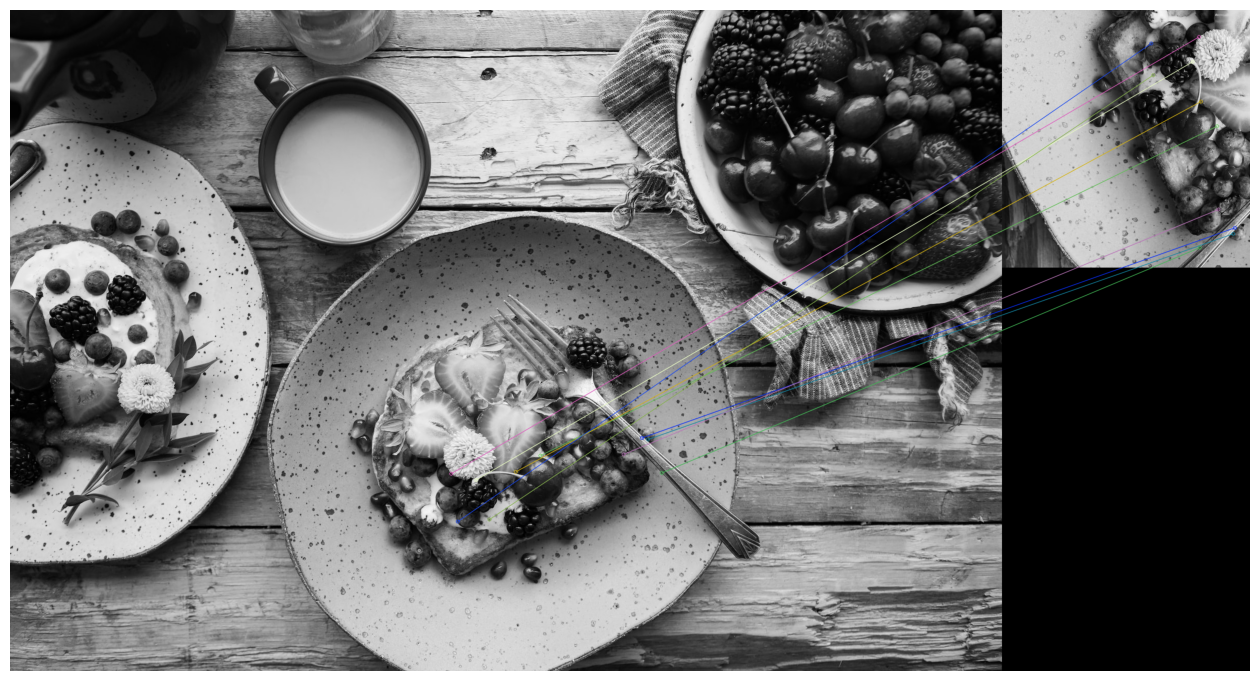

In [199]:
custom_matches = custom_matcher(img1, img1_)
show_matches(custom_matches)

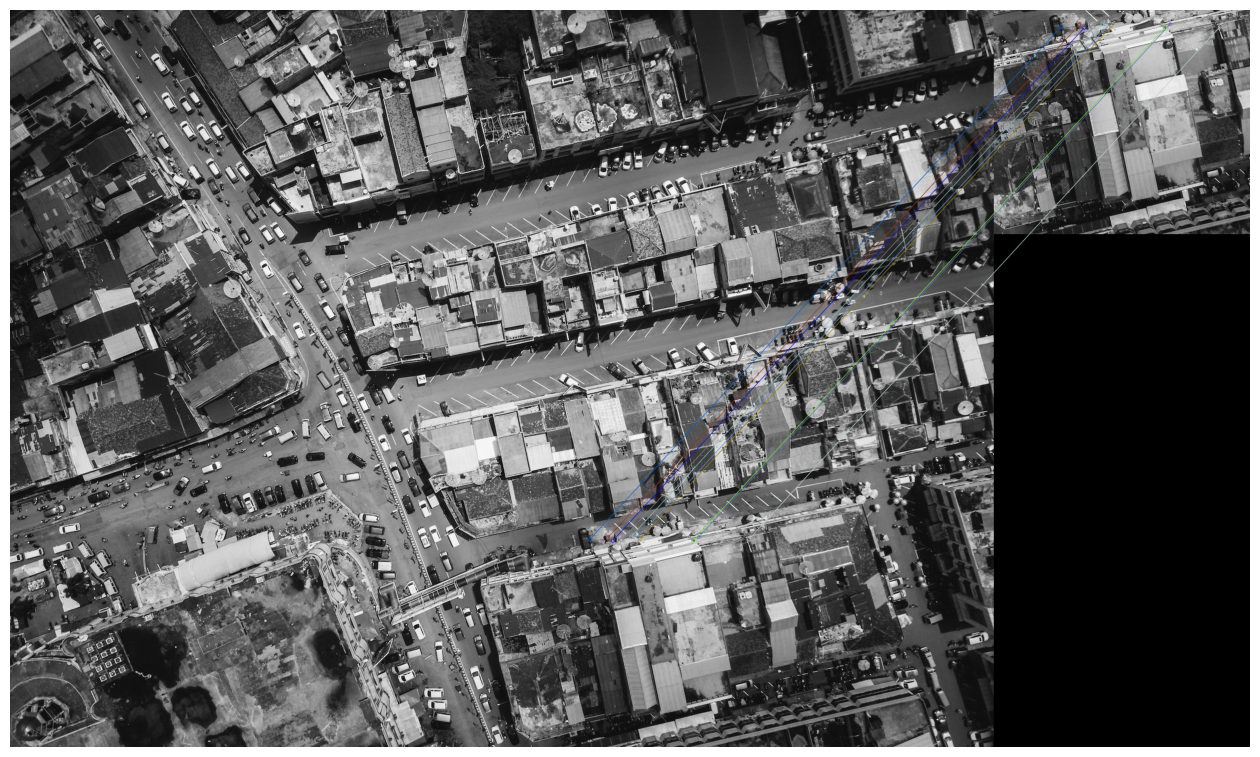

In [147]:
img2 = cv2.imread("top_view.jpeg", cv2.IMREAD_GRAYSCALE)
img2_ = img2[1000:1500, 1000:1500]

cv_matches_2 = cv_bf_matcher(img2, img2_)
show_matches(cv_matches_2)

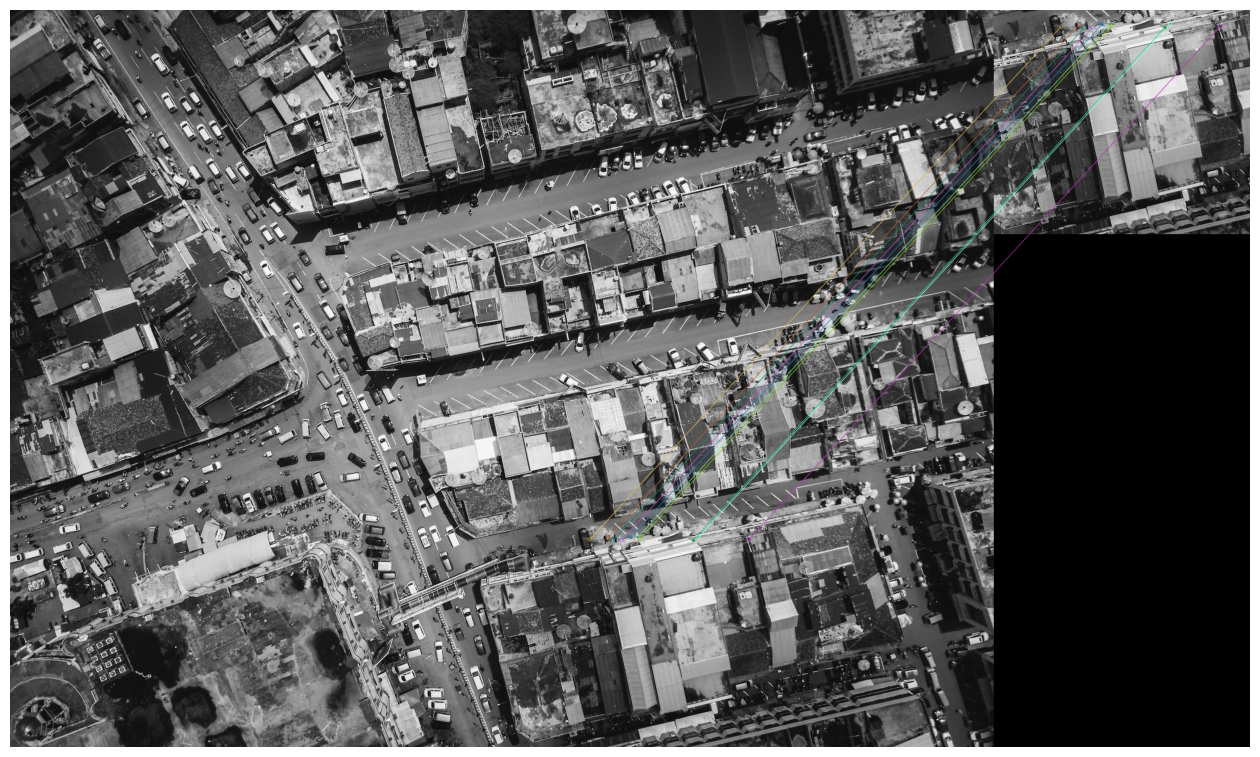

In [176]:
# img2 = cv2.imread("top_view.jpeg", cv2.IMREAD_GRAYSCALE)
# img2_ = img2[1000:1500, 1000:1500]

custom_matches_2 = custom_matcher(img2, img2_)
show_matches(custom_matches_2)

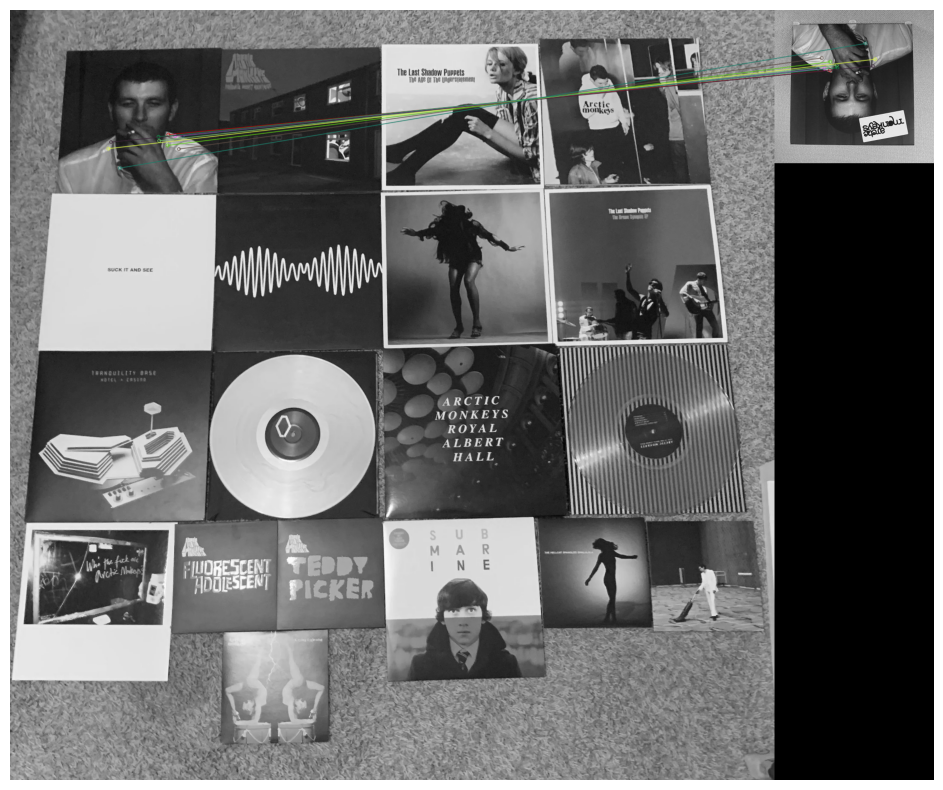

In [177]:
img3 = cv2.imread("vinyls.png", cv2.IMREAD_GRAYSCALE)
img3_ = cv2.imread("am.jpeg", cv2.IMREAD_GRAYSCALE)
img3_ = cv2.rotate(img3_, cv2.ROTATE_180)

custom_matches_3 = cv_bf_matcher(img3, img3_)
show_matches(custom_matches_3)

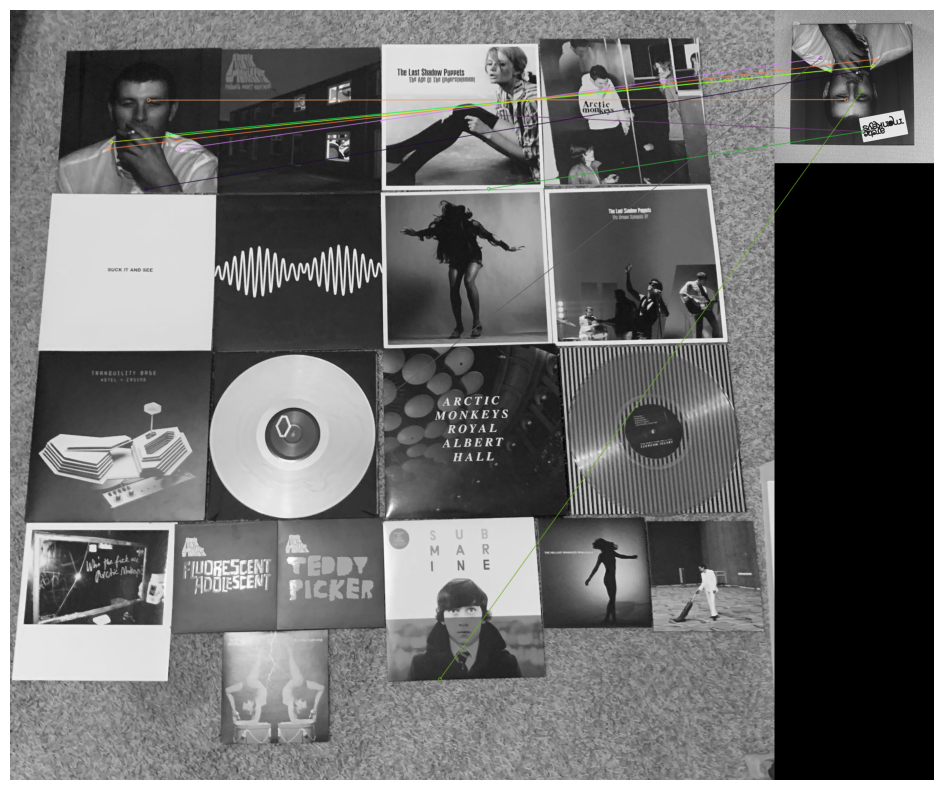

In [178]:
# img4 = cv2.imread("vinyls.png", cv2.IMREAD_GRAYSCALE)
# img4_ = cv2.imread("am.jpeg", cv2.IMREAD_GRAYSCALE)
# img4_ = cv2.rotate(img4_, cv2.ROTATE_180)

custom_matches_4 = custom_matcher(img3, img3_, threshold=750)
show_matches(custom_matches_4)

Додаткове завдання (оцінюється у додаткові бали) - в процесі порівняння дескрипторів використати власну реалізацію алгоритму RANSAC. Додаткові бали також надаються за написання власної функції побудови дексрипторів, без використання OpenCV.

In [201]:
import random

def ransac(
        key_points_1: np.ndarray,
        key_points_2: np.ndarray,
        matches: np.ndarray,
        num_iterations: int = 1_000,
        threshold: float = 100
    ) -> np.ndarray:
    best_inliers = []

    for i in range(num_iterations):
        sample = random.sample(matches, 4)
        src_points = np.float32([key_points_1[m.queryIdx].pt for m in sample]).reshape(-1, 1, 2)
        dst_points = np.float32([key_points_2[m.trainIdx].pt for m in sample]).reshape(-1, 1, 2)
        H, _ = cv2.findHomography(src_points, dst_points, cv2.RANSAC, threshold)

        inliers = []
        for m in range(len(matches)):
            src_point = np.float32(key_points_1[matches[m].queryIdx].pt).reshape(-1, 1, 2)
            dst_point = np.float32(key_points_2[matches[m].trainIdx].pt).reshape(-1, 1, 2)
            dst_pt_transformed = cv2.perspectiveTransform(src_point, H)
            distance = np.linalg.norm(dst_pt_transformed - dst_point)
            if distance < threshold:
                inliers.append(matches[m])

        if len(inliers) > len(best_inliers):
            best_inliers = inliers

    return best_inliers

In [205]:
def ransac_matcher(
        image: np.ndarray,
        query: np.ndarray,
        num_iterations: int =1_000,
        threshold: int = 10,
        n_matches: int = 10
    ) -> np.ndarray:
    akaze = cv2.AKAZE_create()

    kp1, des1 = akaze.detectAndCompute(image, None)
    kp2, des2 = akaze.detectAndCompute(query, None)

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    matches = bf.match(des1, des2)
    inliers = ransac(kp1, kp2, matches, num_iterations, threshold)

    img_matches = cv2.drawMatches(image, kp1, query, kp2, inliers[:n_matches], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    # img_matches = cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB)
    return img_matches

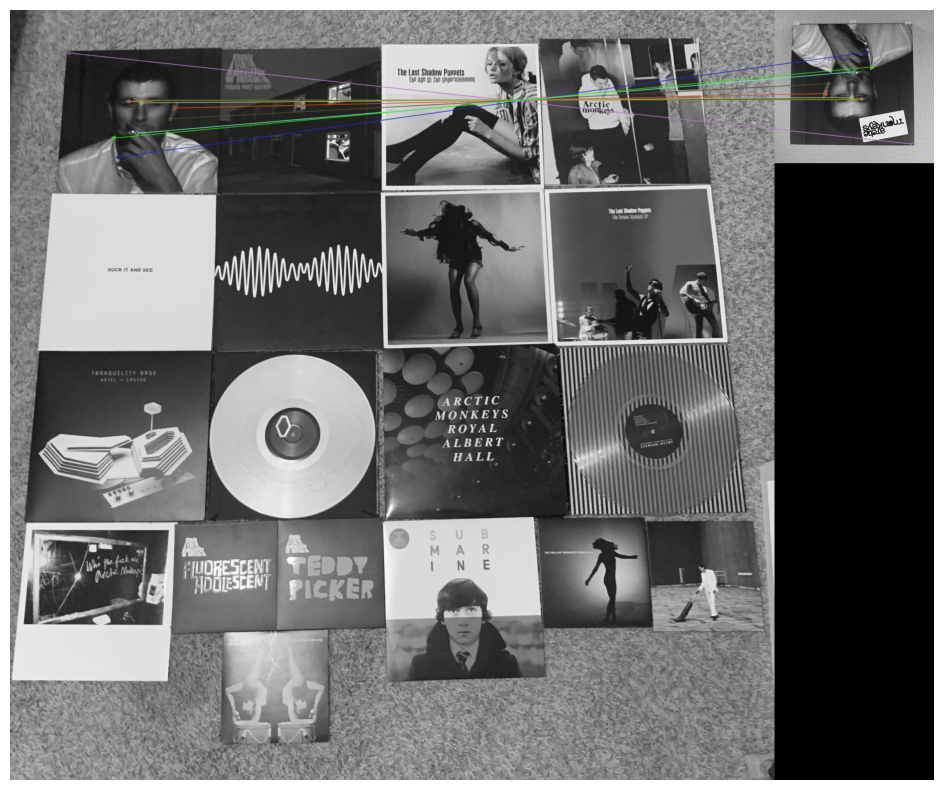

In [206]:
rc_matches = ransac_matcher(img3, img3_)
show_matches(rc_matches)